In [ ]:
# In this notebook we test the quality of the linear relaxation of the semidefinite
#program to compute Lovasz theta number. The linear relaxations are refined by
#adding more and more cuts. This code corresponds to section 4.3 of the paper. 

<h1>functions and plots to evaluate the quality of the linear relaxation of the Lovasz Theta number <h1>

<h2>Table of contents <h2>   
    0. Functions common to different sections, load packages, set seed.<br>
    1. Code for figure 6<br>
    2. Code for figure 7<br>
    3. Code for figure 8<br>
    

   <h3> 0. Functions, load packages,load notebook with SDP and linear relaxation of Lovasz Thetha number, set seed.<h3>


In [1]:
using NBInclude,StatsBase, LightGraphs, Statistics , Random, Distributions,Plots

In [2]:
@nbinclude("LovasThetaFunctions.ipynb")


lovazThetaLP (generic function with 1 method)

In [3]:
Random.seed!(123412341234)

TaskLocalRNG()

<h3>Functions<h3>

In [4]:
#function to plot the objective as more and more cuts are added to the Linear relaxation. For each graph
#generated, we solve the SDP and divide the optimal value of the LP by the optimal value of the SDP.
# we average over numGraphs.
#@param int numGraphs graphs: number of graphs for which we repeat the experiments.
#@param int matrixType: type of matrices for comparaison. if matrixType== d>0 is a regular graph of degree d. If matrixType==0
# we use a matrix with entries distributed as normal(0,20).
#@param float64 p: if the matrix type is erdos-Renyi, p gives the probability of adding an edge between two vertices.
# p must be between 0 and 1.
#@param int rounds: The number of times we add cuts and re-solve the LP. each round adds 10 cuts.
#@param book useSecondOrderConstraints: Indicates if we use the second order constraints to strenghen the 
#linear relaxations or not. This argument is passed to the function solverIteratelyLP.
 function ObjectiveVSIteration(numGraphs,matrixType,p,graphSize,rounds,useSecondOrderConstraints)

    maxNumCuts = rounds*5
    
    #Recall we do increments of 10
    numCols = Int(maxNumCuts/10)
    
    results  =zeros(7,numCols)
    sdpResults = zeros(numGraphs)
      graphs = Array{Any,1}(undef,numGraphs)
      graphsStoredCuts = Array{Any,1}(undef,numGraphs)
      graphsStoredCutsEigen =  Array{Any,1}(undef,numGraphs)
      [graphsStoredCuts[r] = zeros(graphSize) for r in 1:numGraphs]
      J = ones(graphSize)*transpose(ones(graphSize))
       if matrixType==0
        
            for r in 1: numGraphs
            currentGraph =  Matrix(adjacency_matrix(erdos_renyi(graphSize,p)))
            graphs[r]= currentGraph
            end 
       else 
             if isodd(matrixType)
             matrixType=matrixType+1
             end
        
           for r in 1: numGraphs
            currentGraph = Matrix(adjacency_matrix(random_regular_graph(graphSize,matrixType)))
            graphs[r]= currentGraph
            end 
    
    
    end
        
       [ graphsStoredCutsEigen[r] = eigen( J-graphs[r] ).vectors for r in 1:numGraphs]

        [sdpResults[r] = lovazTheta(graphs[r])[2] for r in 1:numGraphs ]
     
    
     count = 1
     cutValue = zeros(numGraphs)
     cutValueEigen = zeros(numGraphs)
    
    for i in 10:10:maxNumCuts
       
        for j in 1:numGraphs
    
            solvedIterated = solverIteratelyLP(graphs[j],5, graphsStoredCuts[j],0,useSecondOrderConstraints)  
             cutValue[j]=solvedIterated[1]
             graphsStoredCuts[j]=  solvedIterated[2]
            
        cutValue[j]= sdpResults[j]/cutValue[j]
           
             solvedIteratedEigen = solverIteratelyLP(graphs[j],5, graphsStoredCutsEigen[j],i,useSecondOrderConstraints)
                cutValueEigen[j]=sdpResults[j]/solvedIteratedEigen[1]
                graphsStoredCutsEigen[j]= solvedIteratedEigen[2]
              
        end
        results[1,count] = i
        results[2,count] = median(cutValue)
        results[3,count] = minimum(cutValue)
        results[4,count] = maximum(cutValue)
        results[5,count] = median(cutValueEigen)
        results[6,count] = minimum(cutValueEigen)
        results[7,count] = maximum(cutValueEigen)
            
       count = count+1 
    end

    return(results)
end



ObjectiveVSIteration (generic function with 1 method)

In [5]:
# Function to compute the linear relaxation of the SDP by adding cuts iteratively. If cuts are precomputed
# they are added as a parameter in Hinicial. This function is called by the function ObjectiveVSIteration.
# @param adjMatrix the  matrix to compute the sparse PCA.
# @param numCuts the number of cuts to generate and add to the linear program.
# @param targetSparcity the sparcity of the PCA components.
# @param Hinicial cuts to add to the linear program, in case they were computed on a previous step.
# @param eigens indicate if  we should use eigenvectors or not. If eigens = 0, the method is not using eigenvectors.
# if eigens = i>0, uses eigens from 1 to i.
#@param book useSecondOrderConstraints: Indicates if we use the second order constraints to strenghen the 
#linear relaxations or not.
function solverIteratelyLP(adjMatrix,numCuts, Hinicial,eigens,useSecondOrderConstraints)
    
    n = size(adjMatrix)[1]
     J = ones(n)*transpose(ones(n))
    m = Model(Mosek.Optimizer)
    set_silent(m)
    resultantH = Hinicial
    
      @variable(m,-1<=X[1:n,1:n]<=1,Symmetric ) 
      @constraint(m,tr(X)==1)
        for i in 1:n
        @constraint(m,X[i,i]>=0)
        for j in 1:i 
            if adjMatrix[i,j]== 1
    @constraint(m,X[i,j]==0)
    @constraint(m,X[j,i]==0)
            end
        end
    end
    
    if(useSecondOrderConstraints==true)
     for i in 1:n
        for j in 1:n
            @constraint(m,[X[i,i]+X[j,j];2*X[i,j];X[i,i]-X[j,j]] in SecondOrderCone())
        end
    end
    
    end
        
    if(eigens>0 && eigens<=n)
        
        for s in 1:eigens
        @constraint(m, transpose(Hinicial[:,s])*X*Hinicial[:,s]>=0)  
        end
    else
        for s in 1:size(Hinicial,2)
        @constraint(m, transpose(Hinicial[:,s])*X*Hinicial[:,s]>=0)  
        end
    end
    
        @objective(m,Max,tr((J-adjMatrix)*X))
         status = optimize!(m)
    
    if(eigens>n)   
        
     for s in 1:numCuts
      maxEigVecto = eigen(value.(X)).vectors[:,1]
      @constraint(m, transpose(maxEigVecto)*X*maxEigVecto>=0)  
      resultantH = hcat(resultantH,maxEigVecto)
      status = optimize!(m)
      end  
        
        
        elseif (eigens==0)
            for s in 1:numCuts
      maxEigVecto = eigen(value.(X)).vectors[:,1]
      @constraint(m, transpose(maxEigVecto)*X*maxEigVecto>=0)  
      resultantH = hcat(resultantH,maxEigVecto)
      status = optimize!(m)
      end  
            end
                
        
    return(objective_value(m),resultantH)

end


solverIteratelyLP (generic function with 1 method)

In [6]:
#function that given a matrix A, stores in the diagonal entry A_ii of A the sum of the values 
# of the entries in the i-th row of A.
# @param matrix A: matrix to compute the rowsums and store the values in the diagonal.
function degreeMatrix(adjMatrix)
   n = size(adjMatrix,1)
   D = zeros(n,n)
    [D[i,i] = sum(adjMatrix[i,:]) for i in 1:n ]
    
    return(D)
    
end

degreeMatrix (generic function with 1 method)

<h2> 1. Code for figure 6<br><h2>

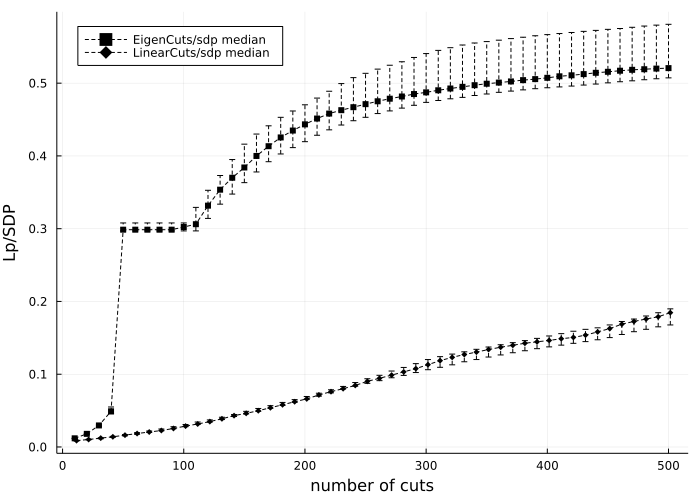

In [7]:
comparedResults = ObjectiveVSIteration(5,0,0.5,50,100,false)
a = vec(transpose(comparedResults[5,:]) - transpose(comparedResults[6,:]))
b = vec(transpose(comparedResults[7,:])-transpose(comparedResults[5,:]))
plotComparedResults= plot(comparedResults[1,:], comparedResults[5,:],marker=(:square, 3, 1.), label =("EigenCuts/sdp median"),legend=:topleft,xaxis ="cuts",yaxis="Lp/SDP" ,size = (700, 500),linestyle=:dash,yerror =(a,b),colour="black"  )
a2 = vec(transpose(comparedResults[2,:])-transpose(comparedResults[3,:]))
b2 = vec(transpose(comparedResults[4,:])-transpose(comparedResults[2,:]))
plot!(comparedResults[1,:].+1.5, comparedResults[2,:], label =("LinearCuts/sdp median"),legend=:topleft,marker=(:diamond, 3, 1.),xaxis ="number of cuts",yaxis="Lp/SDP" ,size = (700, 500),linestyle =:dash,yerror =(a2,b2),colour="black")


  <h2>  2. Code for figure 7<h2>


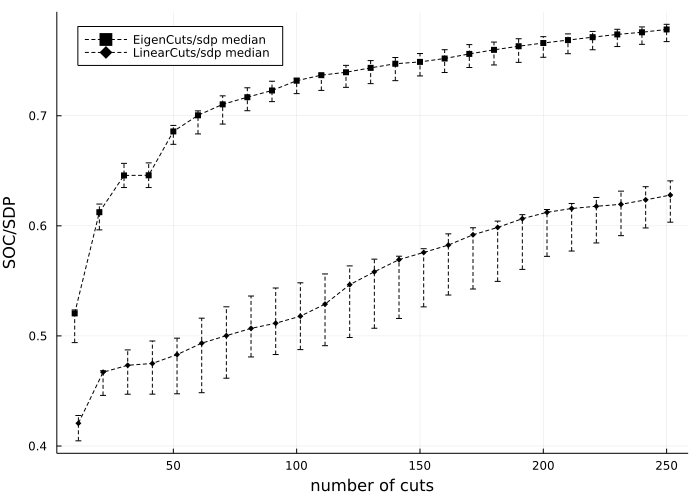

In [8]:
resultRegSOC = ObjectiveVSIteration(5,0,0.5,40,50,true)
comparedResults = resultRegSOC
a = vec(transpose(comparedResults[5,:]) - transpose(comparedResults[6,:]))
b = vec(transpose(comparedResults[7,:])-transpose(comparedResults[5,:]))
plotComparedResults= plot(comparedResults[1,:], comparedResults[5,:],marker=(:square, 3, 1.), label =("EigenCuts/sdp median"),legend=:topleft,xaxis ="cuts",yaxis="SOC/SDP" ,size = (700, 500),linestyle=:dash,yerror =(a,b),colour="black"  )
a2 = vec(transpose(comparedResults[2,:])-transpose(comparedResults[3,:]))
b2 = vec(transpose(comparedResults[4,:])-transpose(comparedResults[2,:]))
plot!(comparedResults[1,:].+1.5, comparedResults[2,:], label =("LinearCuts/sdp median"),legend=:topleft,marker=(:diamond, 3, 1.),xaxis ="number of cuts",yaxis="SOC/SDP" ,size = (700, 500),linestyle =:dash,yerror =(a2,b2),colour="black")


   <h2>3. Code for figure 8<h2>


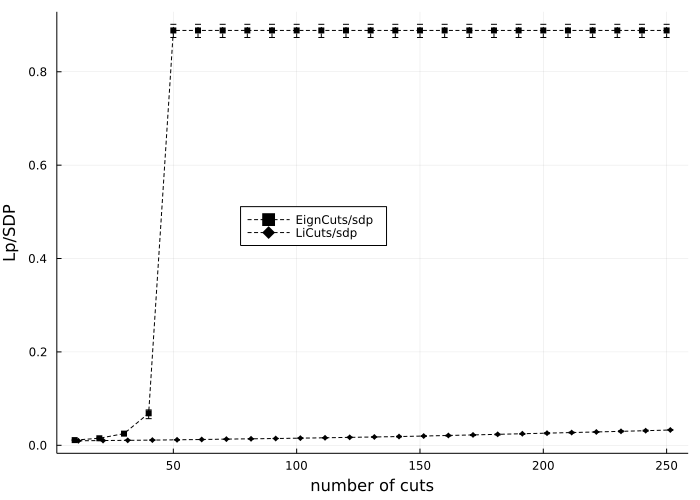

In [9]:
comparedResults = ObjectiveVSIteration(5,6,0.5,50,50,false)
a = vec(transpose(comparedResults[5,:]) - transpose(comparedResults[6,:]))
b = vec(transpose(comparedResults[7,:])-transpose(comparedResults[5,:]))
plotComparedResults= plot(comparedResults[1,:], comparedResults[5,:],marker=(:square, 3, 1.), label =("EignCuts/sdp"),legend=:inside,xaxis ="cuts",yaxis="Lp/SDP" ,size = (700, 500),linestyle=:dash,yerror =(a,b),colour="black"  )
a2 = vec(transpose(comparedResults[2,:])-transpose(comparedResults[3,:]))
b2 = vec(transpose(comparedResults[4,:])-transpose(comparedResults[2,:]))
plot!(comparedResults[1,:].+1.5, comparedResults[2,:], label =("LiCuts/sdp"),legend=:inside,marker=(:diamond, 3, 1.),xaxis ="number of cuts",yaxis="Lp/SDP" ,size = (700, 500),linestyle =:dash,yerror =(a2,b2),colour="black")